In [239]:
%load_ext autoreload
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn.manifold import TSNE
from IPython.display import display, HTML
from copy import copy
from itertools import combinations
from collections import defaultdict, Counter
from scipy.spatial import distance
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from scipy.spatial import distance
from IPython.core.debugger import set_trace
from utils import *
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [240]:
# paths to the databases containing the PCA and Isomap projections 
root = './merged_datasets_transformed/'
root_pca = './merged_datasets_proj/'

paths = [os.path.join(root,path) for path in os.listdir(root)]

paths_pca = [os.path.join(root_pca,path) for path in os.listdir(root_pca)]
paths_mf_lle = list(filter(lambda x: 'lle' in x.split("/")[-1].split(".")[0].split('_'), paths))
paths_mf_isomap = list(filter(lambda x: 'isomap' in x.split("/")[-1].split(".")[0].split('_'), paths))
paths_mf_ae = list(filter(lambda x: 'ae' in x.split("/")[-1].split(".")[0].split('_'), paths))

In [ ]:
data_pca = unpack_data(paths_pca)
data_lle = unpack_data(paths_mf_lle)
data_isomap = unpack_data(paths_mf_isomap)
data_ae = unpack_data(paths_mf_ae)

# Default clusterization

In [243]:
datasets_nums = {'AGP':9511, 'ptb':3457, 't2d':1044, 'ibd':86}
color = {'AGP':'red', 'ptb':'green', 't2d':'blue', 'ibd':'yellow'}
N = sum([i for i in datasets_nums.values()])
    
clusterization_dict = {}

datasets_clusterization = np.zeros(N)
datasets_colors = np.zeros(N).astype(str)
dataset_names = np.zeros(N).astype(str)
i_, i_prev = 0, 0
for k,v in datasets_nums.items():
    datasets_clusterization[i_prev:i_prev+v] = i_
    datasets_colors[i_prev:i_prev+v] = color[k]
    dataset_names[i_prev:i_prev+v] = k
    labels = np.zeros(N)
    labels[i_prev:i_prev+v] = 1
    clusterization_dict[k + '_OVR'] = labels
    i_ += 1
    i_prev += v
clusterization_dict['all'] = datasets_clusterization

#
label = datasets_clusterization.copy()
label[label==1] = 0
label[label==2] = 1
label[label==3] = 2
clusterization_dict['AGP-ptb-vs2'] = label

label = datasets_clusterization.copy()
label[label==2] = 0
label[label==3] = 2
clusterization_dict['AGP-t2d-vs2'] = label

label = datasets_clusterization.copy()
label[label==3] = 0
clusterization_dict['AGP-ibd-vs2'] = label

# 2vsRest
for i,k in enumerate(['ptb', 't2d', 'ibd']):
    label = datasets_clusterization.copy()
    label[label==i] = 0
    label[(label!=0)*(label!=i)] = 1
    clusterization_dict[f'AGP-{k}-vs-rest'] = label

# PCA

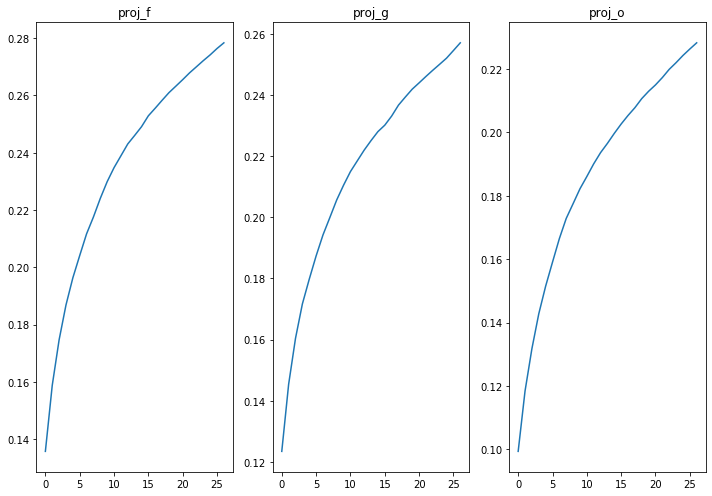

In [5]:
LABEL2DBSCAN_PARAMS_PCA = {}
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for (label,data),ax in zip(data_pca.items(), axes.flatten()):
    p95_list = get_neigh_perc(data)
    ax.plot(p95_list) 
    ax.set_title(label)
    LABEL2DBSCAN_PARAMS_PCA[label] = [min(p95_list), max(p95_list)]
plt.tight_layout()
plt.show()

In [154]:
def get_default_clusterization_metrics(data, clusterization_dict, plot=True):

    # default clusterization metrics
    data_default_metrics = defaultdict(dict)

    for k,v in data.items():
        for clust_name, labels in clusterization_dict.items():
            DB_default = davies_bouldin_score(v, labels)
            Silhoette_default = silhouette_score(v, labels)
            n_clusters = len(np.unique(labels))
            data_default_metrics[k][clust_name] = [n_clusters, DB_default, Silhoette_default]
            
    data_default_metrics_max_silhoette = {}
    for k,v in data_default_metrics.items():
        df = pd.DataFrame(v, index=['n_clusters','Davies-Bouldin index', 'silhouette_score']).T
        df.sort_values(by = 'silhouette_score', ascending=False, inplace=True)
        print(k)
        display(HTML(df.to_html()))
        def_clust_type = df.index[0]
        data_default_metrics_max_silhoette[k] = [def_clust_type, df.loc[def_clust_type].values[-1]]
        
    return data_default_metrics, data_default_metrics_max_silhoette

In [145]:
data_pca_default_metrics, data_pca_default_metrics_max_silhoette = get_default_clusterization_metrics(data_pca, clusterization_dict, plot=True)

proj_f


,n_clusters,Davies-Bouldin index,silhouette_score
AGP_OVR,2.0,3.150182,0.197421
ptb_OVR,2.0,2.331093,0.296661
t2d_OVR,2.0,4.028536,-0.077181
ibd_OVR,2.0,6.133330,0.093995
all,4.0,5.171465,-0.000772
AGP-ptb-vs2,3.0,5.353982,-0.077347
AGP-t2d-vs2,3.0,4.944489,0.157649
AGP-ibd-vs2,3.0,4.453270,-0.000893
AGP-ptb-vs-rest,2.0,3.150182,0.197421
AGP-t2d-vs-rest,2.0,4.335906,-0.063293


proj_g


,n_clusters,Davies-Bouldin index,silhouette_score
AGP_OVR,2.0,3.834085,0.164821
ptb_OVR,2.0,2.848700,0.249776
t2d_OVR,2.0,4.206505,-0.058520
ibd_OVR,2.0,6.145358,0.123654
all,4.0,4.798086,-0.004313
AGP-ptb-vs2,3.0,5.462628,-0.058372
AGP-t2d-vs2,3.0,4.670025,0.158025
AGP-ibd-vs2,3.0,4.388068,-0.004617
AGP-ptb-vs-rest,2.0,3.834085,0.164821
AGP-t2d-vs-rest,2.0,4.571258,-0.043565


proj_o


,n_clusters,Davies-Bouldin index,silhouette_score
AGP_OVR,2.0,2.735321,0.211745
ptb_OVR,2.0,2.087014,0.319264
t2d_OVR,2.0,3.947584,-0.127727
ibd_OVR,2.0,4.880184,0.102122
all,4.0,4.621254,-0.039869
AGP-ptb-vs2,3.0,4.578303,-0.133858
AGP-t2d-vs2,3.0,4.073352,0.167414
AGP-ibd-vs2,3.0,4.310390,-0.035801
AGP-ptb-vs-rest,2.0,2.735321,0.211745
AGP-t2d-vs-rest,2.0,4.315428,-0.109046


In [6]:
methods_dict_pca = {'dbscan':[DBSCAN, [None]*30],
                   'KMeans':[KMeans, np.arange(2, 10, 1)],
                   'SpectralClustering':[SpectralClustering, np.arange(2, 10, 1)]}

methods_names = list(methods_dict_pca.keys())

pca_cluster_results_list = []
pca_cluster_preds_list = []

for method_name in tqdm_notebook(methods_names):
    method_class, param_range = methods_dict_pca[method_name]
    cluster_results, cluster_preds = clustering(data_pca, 
                                                method_class, 
                                                param_range, 
                                                dbscan=method_name=='dbscan', 
                                                dbscan_params_dict=LABEL2DBSCAN_PARAMS_PCA)
    
    pca_cluster_results_list.append(cluster_results)
    pca_cluster_preds_list.append(cluster_preds)

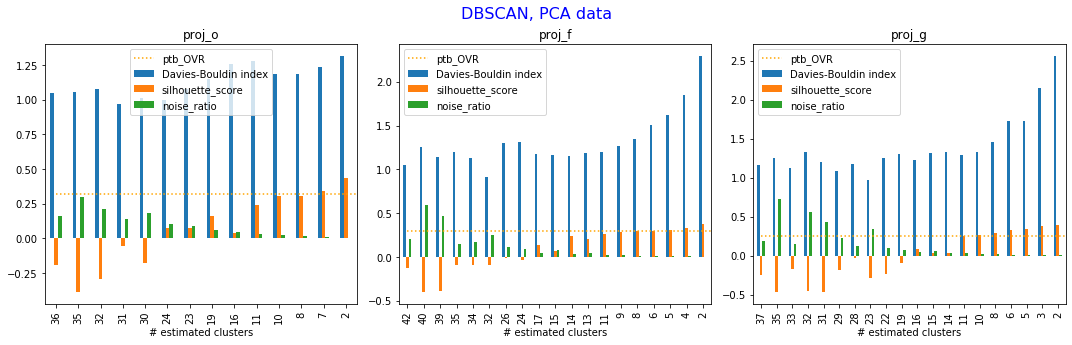

In [160]:
plot_proj_clustering(pca_cluster_results_list[0], suptitle='DBSCAN, PCA data', data_default_metrics=data_pca_default_metrics_max_silhoette)

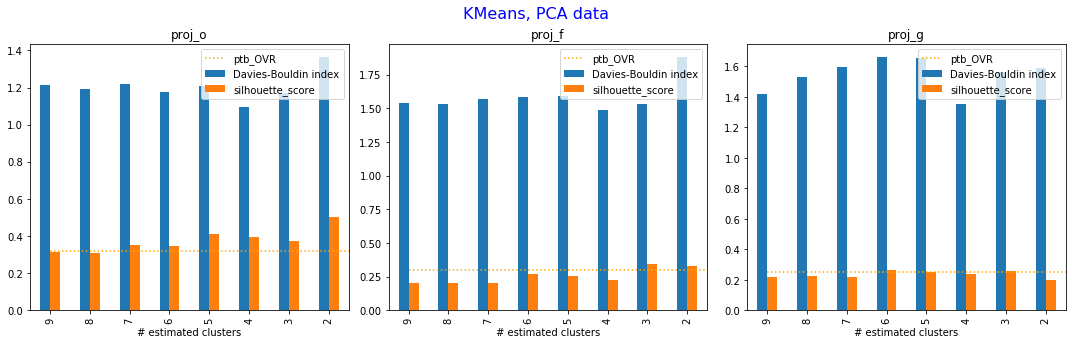

In [161]:
plot_proj_clustering(pca_cluster_results_list[1], suptitle='KMeans, PCA data', data_default_metrics=data_pca_default_metrics_max_silhoette)

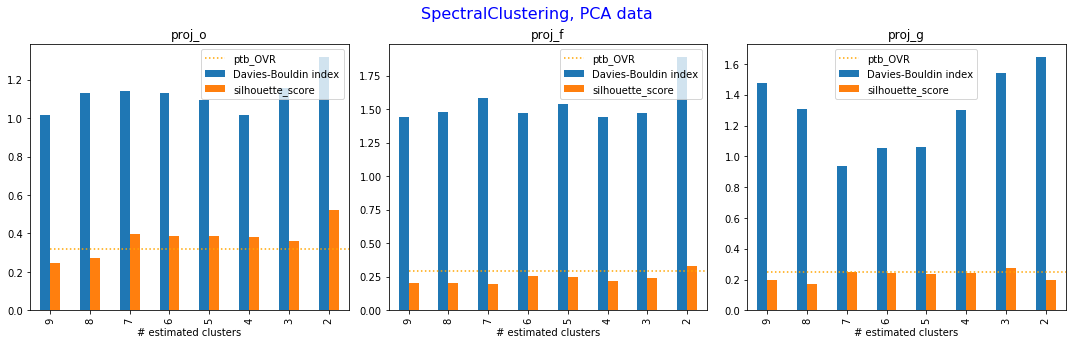

In [162]:
plot_proj_clustering(pca_cluster_results_list[2], suptitle='SpectralClustering, PCA data', data_default_metrics=data_pca_default_metrics_max_silhoette)

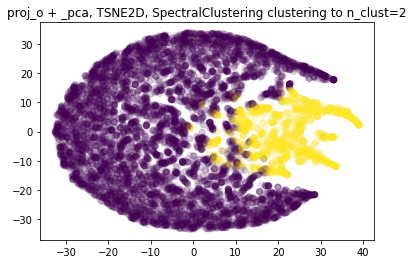

In [260]:
DISTINCT_CLUSTERS_RESULTS_PCA = {'proj_o':{'SpectralClustering':[pca_cluster_preds_list[1]['proj_o'], 2]}}
#                                 'proj_o':{'SpectralClustering':[pca_cluster_preds_list[1]['proj_o'], 4]}}

for label, preds_dict in DISTINCT_CLUSTERS_RESULTS_PCA.items():
    for method_name, (preds, n_clusters) in preds_dict.items():
        dataset = data_pca[label]
        tsne2 = TSNE(2, init='pca', verbose=0, angle=0.3, perplexity=50, n_iter=500, random_state=42)
        tsne2.fit(dataset)
        embedding = tsne2.embedding_
        plt.figure()
        plt.scatter(embedding[:,0], embedding[:,1], alpha=0.1, c=preds[n_clusters])
        plt.title(f'{label} + _pca, TSNE2D, {method_name} clustering to n_clust={n_clusters}')
plt.show()

In [229]:
get_report(methods_dict_pca, 
           pca_cluster_results_list, 
           pca_cluster_preds_list, 
           H_thresh=0.3,
           dbind_thresh=1.2)

------------------------------
dbscan
------------------------------
------------------------------
KMeans
Ratio for proj_o, for n_clusters=3, H=1.0308673941557118, ratios=[0.427 0.403 0.17 ], DBind=1.16993018262097, Silh=0.3718085818444319
Ratio for proj_o, for n_clusters=4, H=1.131786204114616, ratios=[0.426 0.402 0.127 0.045], DBind=1.095567720869177, Silh=0.3974491671584833
------------------------------
------------------------------
SpectralClustering
Ratio for proj_o, for n_clusters=3, H=0.9967861687213928, ratios=[0.448 0.416 0.137], DBind=1.1550012796453297, Silh=0.3635510677534782
Ratio for proj_o, for n_clusters=4, H=1.0677456998667296, ratios=[0.449 0.418 0.101 0.033], DBind=1.0149626854868117, Silh=0.38158347773054824
------------------------------


### PCA: Conclusion

low Silhoette score, high DBindex, normal H

# AE

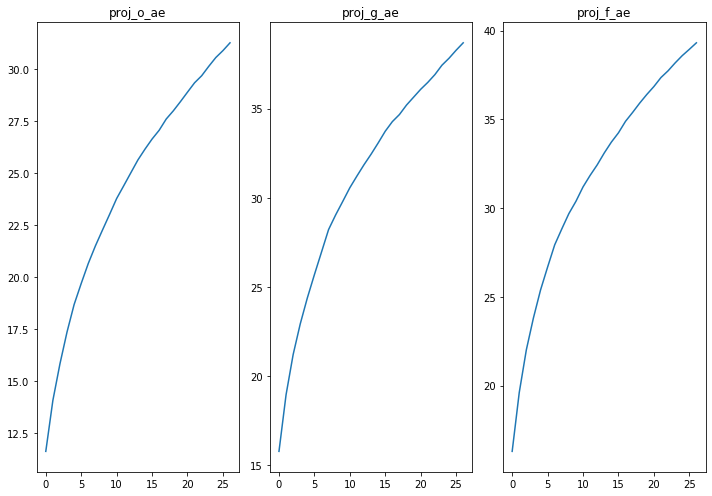

In [246]:
LABEL2DBSCAN_PARAMS_AE = {}
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for (label,data),ax in zip(data_ae.items(), axes.flatten()):
    p95_list = get_neigh_perc(data)
    ax.plot(p95_list)
    ax.set_title(label)
    LABEL2DBSCAN_PARAMS_AE[label] = [min(p95_list), max(p95_list)]
plt.tight_layout()
plt.show()

In [262]:
methods_dict_ae = {'dbscan':[DBSCAN, [None]*10],
                   'KMeans':[KMeans, np.arange(2, 8, 1)]}
#                    'SpectralClustering':[SpectralClustering, np.arange(2, 10, 1)]}

methods_names = list(methods_dict_ae.keys())

ae_cluster_results_list = []
ae_cluster_preds_list = []

for method_name in tqdm_notebook(methods_names):
    method_class, param_range = methods_dict_ae[method_name]
    cluster_results, cluster_preds = clustering(data_ae, 
                                                method_class, 
                                                param_range, 
                                                dbscan=method_name=='dbscan', 
                                                dbscan_params_dict=LABEL2DBSCAN_PARAMS_AE)
    
    ae_cluster_results_list.append(cluster_results)
    ae_cluster_preds_list.append(cluster_preds)

In [263]:
data_ae_default_metrics, data_ae_default_metrics_max_silhoette = get_default_clusterization_metrics(data_ae, clusterization_dict, plot=True)

proj_o_ae


,n_clusters,Davies-Bouldin index,silhouette_score
ptb_OVR,2.0,2.471929,0.349917
AGP-ibd-vs-rest,2.0,2.521744,0.343282
AGP_OVR,2.0,3.081512,0.226093
AGP-ptb-vs-rest,2.0,3.081512,0.226093
AGP-t2d-vs2,3.0,3.857709,0.197692
ibd_OVR,2.0,4.573499,0.130514
all,4.0,4.300247,-0.161598
AGP-ibd-vs2,3.0,4.185302,-0.162511
AGP-t2d-vs-rest,2.0,4.205772,-0.219304
t2d_OVR,2.0,3.965704,-0.250542


proj_g_ae


,n_clusters,Davies-Bouldin index,silhouette_score
ptb_OVR,2.0,2.859407,0.292221
AGP-ibd-vs-rest,2.0,2.912439,0.286620
AGP_OVR,2.0,3.452184,0.188056
AGP-ptb-vs-rest,2.0,3.452184,0.188056
AGP-t2d-vs2,3.0,4.597717,0.155289
ibd_OVR,2.0,5.528646,0.113152
all,4.0,4.568015,-0.122099
AGP-ibd-vs2,3.0,3.737019,-0.122966
AGP-t2d-vs-rest,2.0,4.459261,-0.167210
AGP-ptb-vs2,3.0,5.190176,-0.192141


proj_f_ae


,n_clusters,Davies-Bouldin index,silhouette_score
ptb_OVR,2.0,2.246678,0.359594
AGP-ibd-vs-rest,2.0,2.281608,0.352209
AGP_OVR,2.0,2.847101,0.241372
AGP-ptb-vs-rest,2.0,2.847101,0.241372
AGP-t2d-vs2,3.0,4.649628,0.134484
ibd_OVR,2.0,6.628703,0.009358
all,4.0,4.857533,-0.067422
AGP-ibd-vs2,3.0,4.521348,-0.067955
AGP-t2d-vs-rest,2.0,4.163491,-0.162953
t2d_OVR,2.0,3.960967,-0.179052


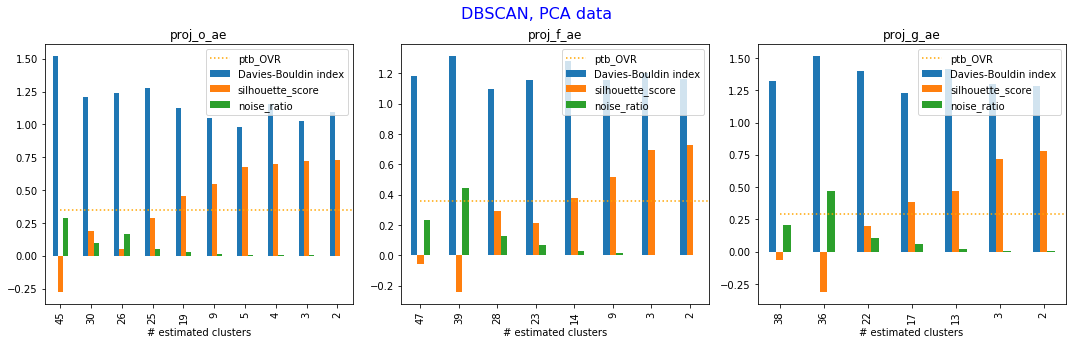

In [264]:
plot_proj_clustering(ae_cluster_results_list[0], method='ae', suptitle='DBSCAN, PCA data', data_default_metrics=data_ae_default_metrics_max_silhoette)

In [266]:
get_report(methods_dict_ae, 
           ae_cluster_results_list, 
           ae_cluster_preds_list, 
           data_ae_default_metrics_max_silhoette,
           H_thresh=0.0,
           dbind_thresh=1.5)

------------------------------
dbscan
Ratio for proj_o_ae, for n_clusters=3, H=0.027611835822998927, ratios=[0.996 0.003 0.    0.   ], DBind=1.0274515534735633, Silh=0.7230177521705627
Ratio for proj_o_ae, for n_clusters=2, H=0.020672997223670067, ratios=[0.997 0.002 0.   ], DBind=1.0926509067487966, Silh=0.7327801585197449
Ratio for proj_g_ae, for n_clusters=2, H=0.024702343555809813, ratios=[0.996 0.003 0.   ], DBind=1.282183652566829, Silh=0.7808880805969238
Ratio for proj_g_ae, for n_clusters=3, H=0.052878220938291795, ratios=[0.991 0.008 0.    0.   ], DBind=1.2956230961377073, Silh=0.718437135219574
Ratio for proj_f_ae, for n_clusters=3, H=0.024123756158450502, ratios=[0.997 0.003 0.    0.   ], DBind=1.2040598222309506, Silh=0.6954393982887268
Ratio for proj_f_ae, for n_clusters=2, H=0.015155325369818444, ratios=[0.998 0.002 0.   ], DBind=1.1644727367820729, Silh=0.7286742329597473
------------------------------
------------------------------
KMeans
Ratio for proj_o_ae, for n_clus

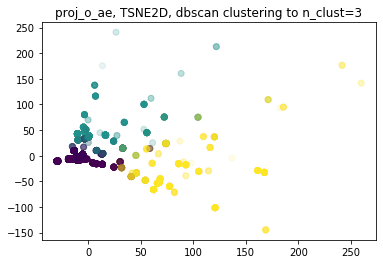

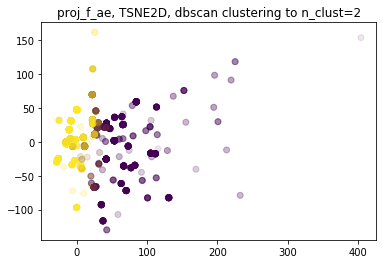

In [268]:
DISTINCT_CLUSTERS_RESULTS_AE = {'proj_o_ae':{'dbscan':[ae_cluster_preds_list[1]['proj_o_ae'], 3]},
                                'proj_f_ae':{'dbscan':[ae_cluster_preds_list[1]['proj_f_ae'], 2]}}

for label, preds_dict in DISTINCT_CLUSTERS_RESULTS_AE.items():
    for method_name, (preds, n_clusters) in preds_dict.items():
        dataset = data_ae[label]
        tsne2 = TSNE(2, init='pca', verbose=0, angle=0.3, perplexity=50, n_iter=251, random_state=42)
        tsne2.fit(dataset)
        embedding = tsne2.embedding_
        plt.figure()
        plt.scatter(embedding[:,0], embedding[:,1], alpha=0.1, c=preds[n_clusters])
        plt.title(f'{label}, TSNE2D, {method_name} clustering to n_clust={n_clusters}')
plt.show()

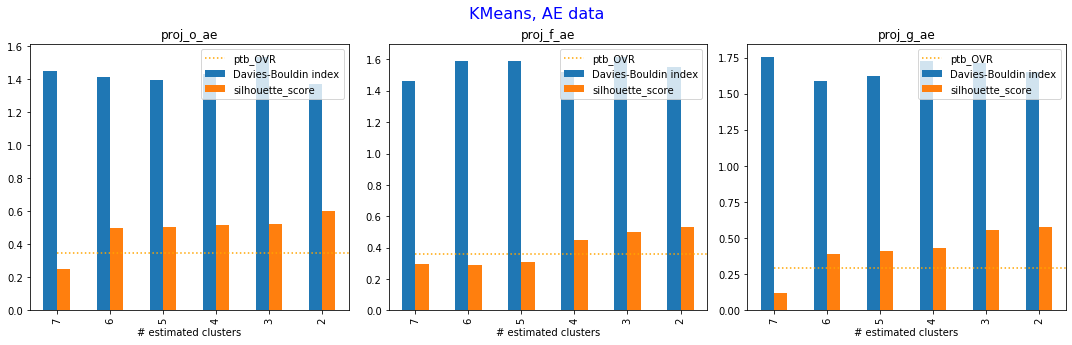

In [265]:
plot_proj_clustering(ae_cluster_results_list[1], method='ae', suptitle='KMeans, AE data', data_default_metrics=data_ae_default_metrics_max_silhoette)

In [ ]:
# plot_proj_clustering(ae_cluster_results_list[2], method='ae', suptitle='DBSCAN, PCA data', data_default_metrics=data_ae_default_metrics_max_silhoette)

# Isomap

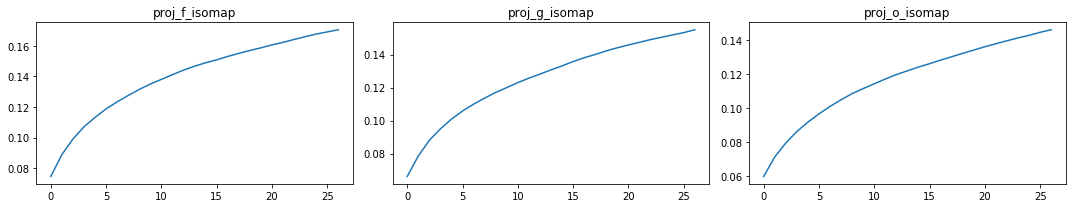

In [9]:
LABEL2DBSCAN_PARAMS_ISOMAP = {}
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
for (label,data),ax in zip(data_isomap.items(), axes.flatten()):
    p95_list = get_neigh_perc(data)
    ax.plot(p95_list)
    ax.set_title(label)
    LABEL2DBSCAN_PARAMS_ISOMAP[label] = [min(p95_list), max(p95_list)]
plt.tight_layout()
plt.show()

In [163]:
data_isomap_default_metrics, data_isomap_default_metrics_max_silhoette = get_default_clusterization_metrics(data_isomap, clusterization_dict, plot=True)

proj_f_isomap


,n_clusters,Davies-Bouldin index,silhouette_score
ptb_OVR,2.0,1.881562,0.350163
AGP-ibd-vs-rest,2.0,1.930415,0.342438
AGP_OVR,2.0,2.556136,0.236823
AGP-ptb-vs-rest,2.0,2.556136,0.236823
AGP-t2d-vs2,3.0,5.150730,0.144015
ibd_OVR,2.0,4.971970,0.032360
AGP-ibd-vs2,3.0,4.241918,0.012967
all,4.0,5.332587,0.010803
AGP-t2d-vs-rest,2.0,3.810690,-0.081280
t2d_OVR,2.0,3.633412,-0.092005


proj_g_isomap


,n_clusters,Davies-Bouldin index,silhouette_score
ptb_OVR,2.0,2.169311,0.288139
AGP-ibd-vs-rest,2.0,2.214273,0.282551
AGP_OVR,2.0,2.904560,0.194449
AGP-ptb-vs-rest,2.0,2.904560,0.194449
AGP-t2d-vs2,3.0,3.902358,0.145766
ibd_OVR,2.0,4.993639,0.077777
AGP-ibd-vs2,3.0,4.758176,0.018504
all,4.0,4.804042,0.014635
AGP-t2d-vs-rest,2.0,4.582116,-0.045324
t2d_OVR,2.0,4.294502,-0.056373


proj_o_isomap


,n_clusters,Davies-Bouldin index,silhouette_score
ptb_OVR,2.0,2.130562,0.309327
AGP-ibd-vs-rest,2.0,2.178809,0.303341
AGP_OVR,2.0,2.720091,0.208264
AGP-ptb-vs-rest,2.0,2.720091,0.208264
AGP-t2d-vs2,3.0,3.894138,0.166081
ibd_OVR,2.0,4.683238,0.108099
AGP-ibd-vs2,3.0,4.584976,-0.017852
all,4.0,4.756585,-0.027521
AGP-t2d-vs-rest,2.0,5.194842,-0.090949
t2d_OVR,2.0,4.676286,-0.108588


In [11]:
methods_dict_isomap = {'dbscan':[DBSCAN, [None]*30],
                       'KMeans':[KMeans, np.arange(2, 10, 1)],
                       'SpectralClustering':[SpectralClustering, np.arange(2, 10, 1)]}

methods_names = list(methods_dict_isomap.keys())

isomap_cluster_results_list = []
isomap_cluster_preds_list = []

for method_name in tqdm_notebook(methods_names):
    method_class, param_range = methods_dict_isomap[method_name]
    cluster_results, cluster_preds = clustering(data_isomap, 
                                                method_class, 
                                                param_range, 
                                                dbscan=method_name=='dbscan', 
                                                dbscan_params_dict=LABEL2DBSCAN_PARAMS_ISOMAP)
    
    isomap_cluster_results_list.append(cluster_results)
    isomap_cluster_preds_list.append(cluster_preds)

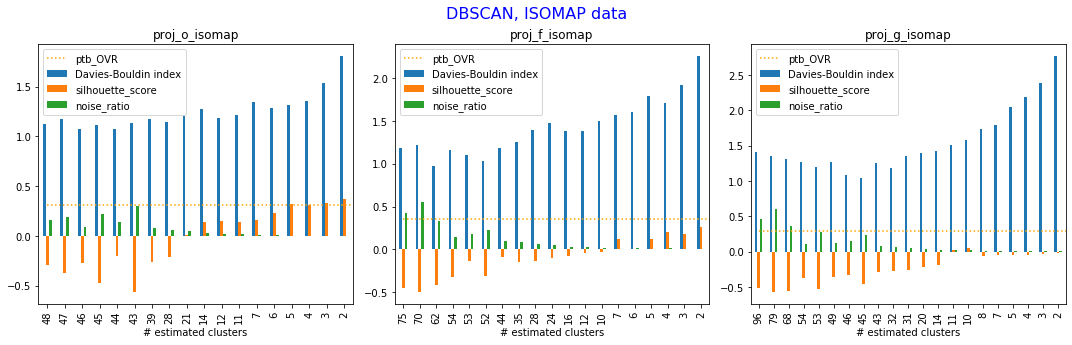

In [170]:
plot_proj_clustering(isomap_cluster_results_list[0], method='isomap', suptitle='DBSCAN, ISOMAP data', data_default_metrics=data_isomap_default_metrics_max_silhoette)

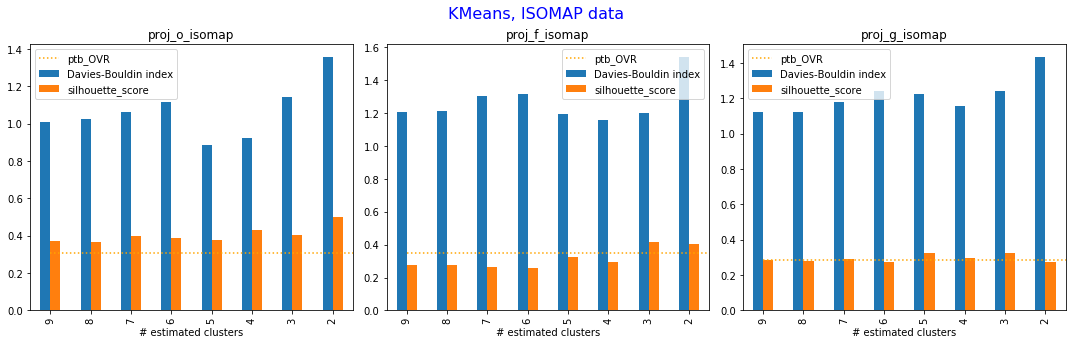

In [171]:
plot_proj_clustering(isomap_cluster_results_list[1], method='isomap', suptitle='KMeans, ISOMAP data', data_default_metrics=data_isomap_default_metrics_max_silhoette)

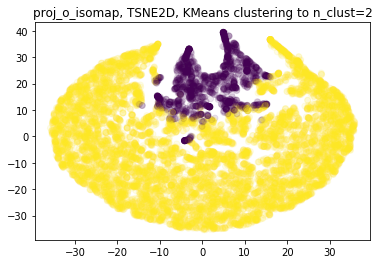

In [259]:
DISTINCT_CLUSTERS_RESULTS_ISOMAP = {'proj_o_isomap':{'KMeans':[isomap_cluster_preds_list[1]['proj_o_isomap'], 2]}}
#                                 'proj_o_isomap':{'KMeans':[isomap_cluster_preds_list[1]['proj_o_isomap'], 4]}}

for label, preds_dict in DISTINCT_CLUSTERS_RESULTS_ISOMAP.items():
    for method_name, (preds, n_clusters) in preds_dict.items():
        dataset = data_isomap[label]
        tsne2 = TSNE(2, init='pca', verbose=0, angle=0.3, perplexity=50, n_iter=500, random_state=42)
        tsne2.fit(dataset)
        embedding = tsne2.embedding_
        plt.figure()
        plt.scatter(embedding[:,0], embedding[:,1], alpha=0.1, c=preds[n_clusters])
        plt.title(f'{label}, TSNE2D, {method_name} clustering to n_clust={n_clusters}')
plt.show()

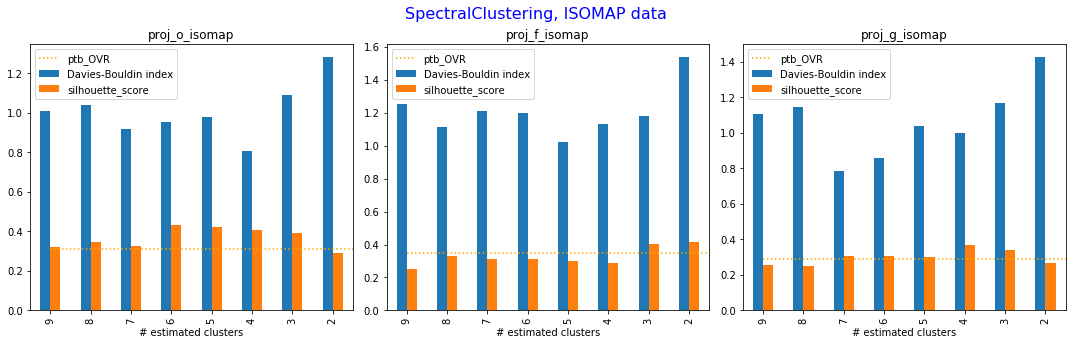

In [172]:
plot_proj_clustering(isomap_cluster_results_list[2], method='isomap', suptitle='SpectralClustering, ISOMAP data', data_default_metrics=data_isomap_default_metrics_max_silhoette)

In [226]:
get_report(methods_dict_isomap, 
           isomap_cluster_results_list, 
           isomap_cluster_preds_list, 
           data_isomap_default_metrics_max_silhoette,
           H_thresh=0.3,
           dbind_thresh=1.)

------------------------------
dbscan
------------------------------
------------------------------
KMeans
Ratio for proj_o_isomap, for n_clusters=4, H=1.1047294037118094, ratios=[0.449 0.402 0.102 0.048], DBind=0.9241223241456928, Silh=0.43082151882339664
------------------------------
------------------------------
SpectralClustering
Ratio for proj_g_isomap, for n_clusters=4, H=0.9692667747706745, ratios=[0.64  0.195 0.142 0.023], DBind=0.9963694008106787, Silh=0.3681208399889855
Ratio for proj_o_isomap, for n_clusters=4, H=1.0112548022574748, ratios=[0.495 0.405 0.039 0.061], DBind=0.8070632416418635, Silh=0.40800962042302985
------------------------------


# LLE

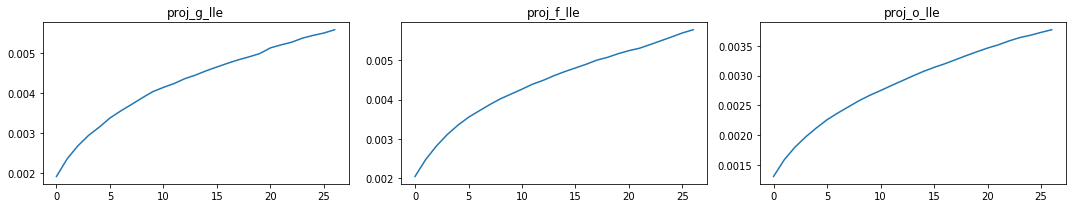

In [12]:
LABEL2DBSCAN_PARAMS_LLE = {}
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
for (label,data),ax in zip(data_lle.items(), axes.flatten()):
    p95_list = get_neigh_perc(data)
    ax.plot(p95_list)
    ax.set_title(label)
    LABEL2DBSCAN_PARAMS_LLE[label] = [min(p95_list), max(p95_list)]
plt.tight_layout()
plt.show()

In [13]:
methods_dict_lle = {'dbscan':[DBSCAN, [None]*30],
                       'KMeans':[KMeans, np.arange(2, 10, 1)],
                       'SpectralClustering':[SpectralClustering, np.arange(2, 10, 1)]}

methods_names = list(methods_dict_lle.keys())

lle_cluster_results_list = []
lle_cluster_preds_list = []

for method_name in tqdm_notebook(methods_names):
    method_class, param_range = methods_dict_lle[method_name]
    cluster_results, cluster_preds = clustering(data_lle, 
                                                method_class, 
                                                param_range, 
                                                dbscan=method_name=='dbscan', 
                                                dbscan_params_dict=LABEL2DBSCAN_PARAMS_LLE)
    
    lle_cluster_results_list.append(cluster_results)
    lle_cluster_preds_list.append(cluster_preds)

In [173]:
data_lle_default_metrics, data_lle_default_metrics_max_silhoette = get_default_clusterization_metrics(data_lle, clusterization_dict, plot=True)

proj_g_lle


,n_clusters,Davies-Bouldin index,silhouette_score
ptb_OVR,2.0,3.017784,0.313081
AGP-ibd-vs-rest,2.0,3.052695,0.307161
AGP_OVR,2.0,3.730688,0.213486
AGP-ptb-vs-rest,2.0,3.730688,0.213486
AGP-t2d-vs2,3.0,5.526941,0.183712
ibd_OVR,2.0,8.785634,0.143017
all,4.0,5.486582,-0.008633
AGP-ibd-vs2,3.0,4.807588,-0.008799
AGP-t2d-vs-rest,2.0,5.549609,-0.075072
AGP-ptb-vs2,3.0,7.610233,-0.094540


proj_f_lle


,n_clusters,Davies-Bouldin index,silhouette_score
ptb_OVR,2.0,2.617574,0.361944
AGP-ibd-vs-rest,2.0,2.672178,0.354353
AGP_OVR,2.0,3.291412,0.252502
AGP-ptb-vs-rest,2.0,3.291412,0.252502
AGP-t2d-vs2,3.0,5.358792,0.145055
ibd_OVR,2.0,5.732138,0.035988
AGP-ibd-vs2,3.0,4.408486,0.016785
all,4.0,5.489130,0.014216
AGP-t2d-vs-rest,2.0,4.968929,-0.090405
t2d_OVR,2.0,4.664863,-0.101707


proj_o_lle


,n_clusters,Davies-Bouldin index,silhouette_score
ptb_OVR,2.0,2.718551,0.225926
AGP-ibd-vs-rest,2.0,2.774961,0.221948
AGP_OVR,2.0,3.557094,0.148454
AGP-ptb-vs-rest,2.0,3.557094,0.148454
AGP-t2d-vs2,3.0,4.052015,0.148353
ibd_OVR,2.0,4.822120,0.138281
AGP-ibd-vs2,3.0,5.277359,-0.004566
all,4.0,5.180321,-0.009261
AGP-t2d-vs-rest,2.0,5.714582,-0.034646
t2d_OVR,2.0,5.288319,-0.050567


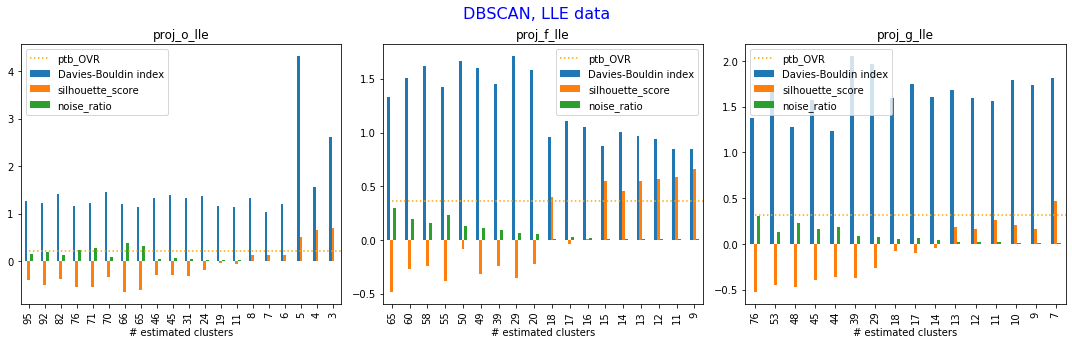

In [174]:
plot_proj_clustering(lle_cluster_results_list[0], method='lle', suptitle='DBSCAN, LLE data', data_default_metrics=data_lle_default_metrics_max_silhoette)

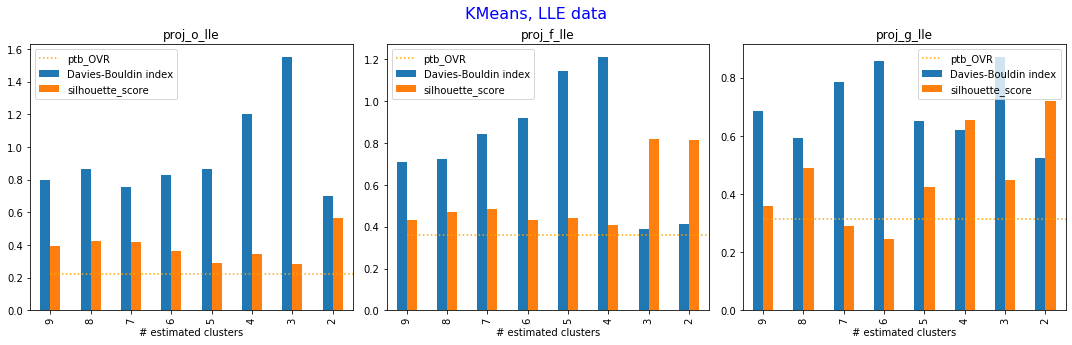

In [175]:
plot_proj_clustering(lle_cluster_results_list[1], method='lle', suptitle='KMeans, LLE data', data_default_metrics=data_lle_default_metrics_max_silhoette)

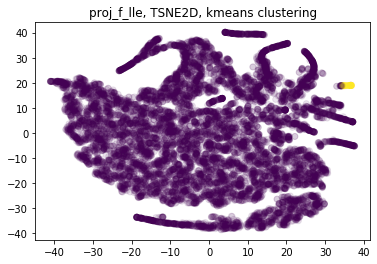

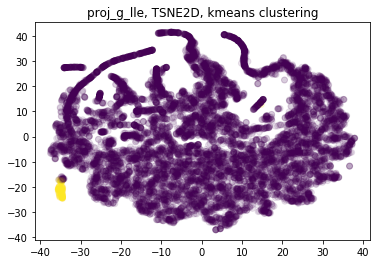

In [253]:

DISTINCT_CLUSTERS_RESULTS = {'proj_f_lle':{'kmeans':lle_cluster_preds_list[1]['proj_f_lle']},
                            'proj_g_lle':{'kmeans':lle_cluster_preds_list[1]['proj_g_lle']}}
n_clusters = 2
for label, preds_dict in DISTINCT_CLUSTERS_RESULTS.items():
    for method_name, preds in preds_dict.items():
        dataset = data_lle[label]
        tsne2 = TSNE(2, init='pca', verbose=0, angle=0.3, perplexity=50, n_iter=500, random_state=42)
        tsne2.fit(dataset)
        embedding = tsne2.embedding_
        plt.figure()
        plt.scatter(embedding[:,0], embedding[:,1], alpha=0.1, c=preds[2])
        plt.title(f'{label}, TSNE2D, {method_name} clustering')
plt.show()

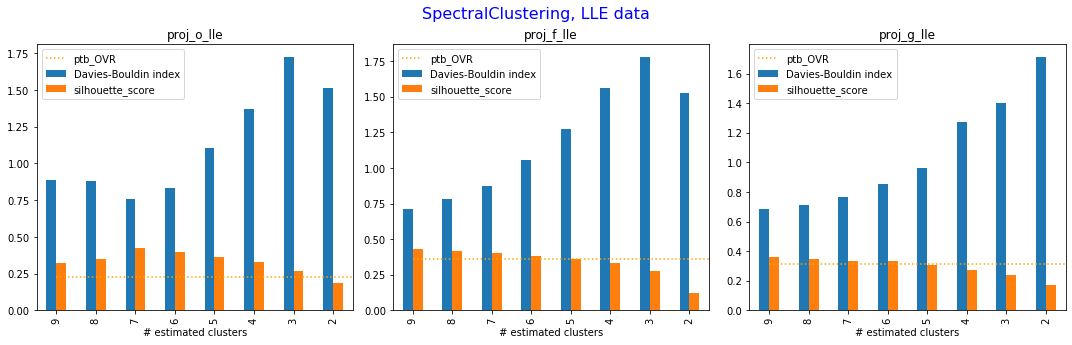

In [176]:
plot_proj_clustering(lle_cluster_results_list[2], method='lle', suptitle='SpectralClustering, LLE data', data_default_metrics=data_lle_default_metrics_max_silhoette)

In [222]:
get_report(methods_dict_lle, 
           lle_cluster_results_list, 
           lle_cluster_preds_list, 
           data_lle_default_metrics_max_silhoette, 
           dbind_thresh=0.6,
           H_thresh=0)

------------------------------
dbscan
------------------------------
------------------------------
KMeans
Ratio for proj_g_lle, for n_clusters=2, H=0.057631429750693644, ratios=[0.99 0.01], DBind=0.5238766680457017, Silh=0.7205734593982233
Ratio for proj_f_lle, for n_clusters=2, H=0.02670552919776514, ratios=[0.996 0.004], DBind=0.4114801233019688, Silh=0.8133240708333209
Ratio for proj_f_lle, for n_clusters=3, H=0.046994999423487234, ratios=[0.993 0.003 0.004], DBind=0.38743491585317136, Silh=0.8174879995652355
------------------------------
------------------------------
SpectralClustering
------------------------------
